In [1]:
import sys

sys.path.insert(0, "/home/esrf/james1997a/Code/ImageD11")

In [2]:
from ImageD11.grain import grain
from ImageD11.unitcell import unitcell
import numpy as np
from scipy.spatial.transform import Rotation as R

from orix.quaternion import Orientation, Rotation
from orix.quaternion.symmetry import get_point_group
from orix.vector import Miller
from orix.crystal_map import Phase
from orix.plot import IPFColorKeyTSL
from orix.vector.vector3d import Vector3d

from diffpy.structure import Lattice, Structure

from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
hexagonal_ucell_array = np.array([2.94, 2.94, 2.94, 90, 90, 120])
hexagonal_ucell = unitcell(hexagonal_ucell_array)
B = hexagonal_ucell.B

In [4]:
# generate 1000 random orientations

Us = R.random(1000).as_matrix()

In [5]:
UBs = Us @ B

In [6]:
UBIs = np.linalg.inv(UBs)

In [7]:
# make grain object

grains = [grain(UBI) for UBI in UBIs]

In [8]:
# populate spacegroups

for g in grains:
    g.spacegroup = 194  # hexagonal

In [9]:
def ipf_plot_grains_list(grains, ipf_direction=np.array([0, 0, 1])):
    if not isinstance(ipf_direction, Vector3d):
        # make it a Vector3D if not already
        ipf_direction = Vector3d(ipf_direction)
    
    # get all the orientations
    orix_oriens = [g.orix_orien for g in grains]
    
    # get all the orix orientation matrices
    orix_mats = np.array([orien.to_matrix() for orien in orix_oriens])
    
    # get the symmetry and point group from one of the grains
    symmetry = grains[0].orix_orien.symmetry
    pg = grains[0].orix_phase.point_group
    
    # make a combined orientation from them (makes plot much faster)
    meta_orien = Orientation.from_matrix(orix_mats, symmetry=symmetry)
    
    # get the IPF key
    ipfkey = IPFColorKeyTSL(pg, direction=ipf_direction)
    
    # get the color for all the orientations
    rgb = ipfkey.orientation2color(meta_orien)
    
    # scatter them
    meta_orien.scatter("ipf", c=rgb, direction=ipfkey.direction)

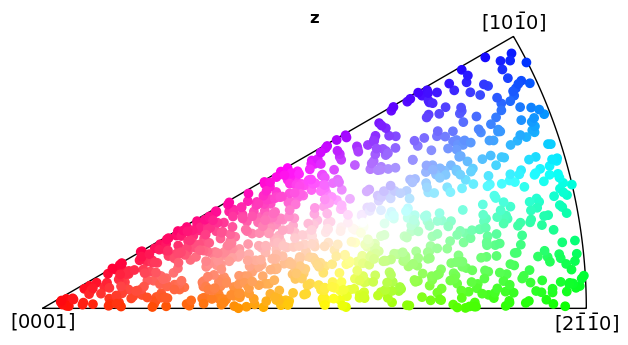

In [10]:
ipf_plot_grains_list(grains)

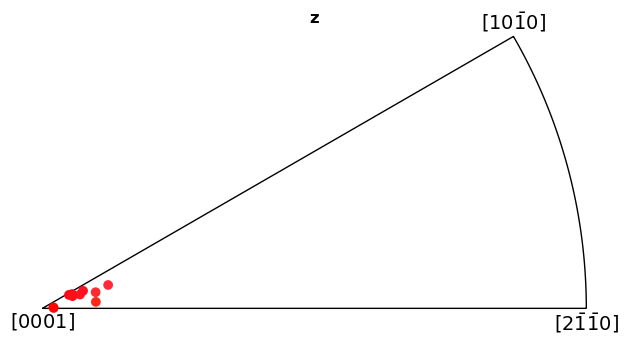

In [11]:
# generate 10 orientations clustered near identity
# they'll all be rotated around x and y such that c* doesn't point exactly || z

Us = R.from_euler(seq='xy', angles=(np.random.random((10, 2))-0.5)*25, degrees=True).as_matrix()

UBs = Us @ B

UBIs = np.linalg.inv(UBs)

grains = [grain(UBI) for UBI in UBIs]

for g in grains:
    g.spacegroup = 194

ipf_plot_grains_list(grains)

In [12]:
def pf_plot_grains_list(grains, uvw=np.array([1., 0., 0.])):
    
    # get all the orientations
    orix_oriens = [g.orix_orien for g in grains]
    
    # get all the orix orientation matrices
    orix_mats = np.array([orien.to_matrix() for orien in orix_oriens])
    
    # get the symmetry, phase and point group from one of the grains
    symmetry = grains[0].orix_orien.symmetry
    phase = grains[0].orix_phase
    pg = phase.point_group
    
    # make a combined orientation from them (makes plot much faster)
    meta_orien = Orientation.from_matrix(orix_mats, symmetry=symmetry)
    
    # make Miller object from uvw
    m1 = Miller(uvw=uvw, phase=phase).symmetrise(unique=True)
    
    # get outer product of all orientations with the crystal direction we're interested in
    uvw_all = (~meta_orien).outer(m1)
    
    # split this into upper or lower based on z sign
    # this is because mpl stereographic will only plot z > 0 points
    
    uvw_all_upper = uvw_all[uvw_all.z > 0]
    uvw_all_lower = uvw_all[uvw_all.z < 0]
    
    # force z positive for lower half of plot
    
    uvw_all_lower.z = -(uvw_all_lower.z)
    
    fig, axs = plt.subplots(1, 2, layout="constrained", subplot_kw={'projection':"stereographic"})
    axs[0].scatter(uvw_all_upper)
    axs[0].set_labels("X", "Y", None)
    axs[0].set_title("upper")
    
    axs[1].scatter(uvw_all_lower)
    axs[1].set_labels("X", "Y", None)
    axs[1].set_title("lower")
    
    plt.suptitle(np.array2string(uvw, precision=2) + " pole figure")

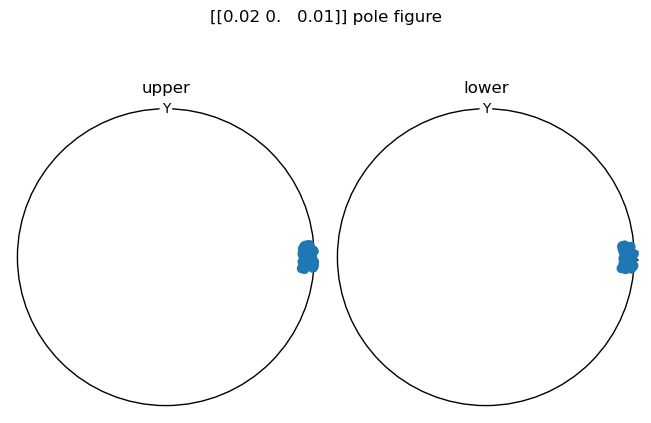

In [13]:
# let's test a triclinic too:

# Labradorite
# ICSD 100232
# 8.1736 12.8736 7.1022 93.462 116.054 90.475
# space group 2
triclinic_ucell_array = np.array([8.1736, 12.8736, 7.1022, 93.462, 116.054, 90.475])
triclinic_ucell = unitcell(triclinic_ucell_array, symmetry="C")

B = triclinic_ucell.B

# establish some orientations that are all close to a* || x
# we do this by rotating around y and z slightly

Us = R.from_euler(seq='yz', angles=(np.random.random((100, 2))-0.5)*10, degrees=True).as_matrix()

UBs = Us @ B

UBIs = np.linalg.inv(UBs)

grains = [grain(UBI) for UBI in UBIs]

for g in grains:
    g.spacegroup = 1

# U is identity
# a* should be along x_lab

uvw = Miller(hkl=(1,0,0),phase=grains[0].orix_phase).uvw

pf_plot_grains_list(grains, uvw)